# HPMS Sample Management

- 20: Create table of potential samples based on the intersection of specific Sections data items according to the HPMS Field Manual.
- 23: Calculate expansion factors as specified in the HPMS Field Manual.
- 24: Generate Sample Adequacy report based on the adequacy specifications in the HPMS Field Manual.

#### Setup:

In [205]:
# Import needed modules
import arcgis
import pandas as pd
import os
import arcpy  # Best practice: Load arcpy last to maintain priority for namespace
from pprint import pprint

In [206]:
# Set reference to raw HPMS dataset and the pre-processed TOPS shapefile
hpms_shp = r"C:\Users\albe9057\Documents\3_Presentations\20191219_FHWA_HPMS_RFI_Notebook\newyork2014\NewYork2014.shp"
tops_shp = r"C:\Users\albe9057\Documents\3_Presentations\20191219_FHWA_HPMS_RFI_Notebook\NewYork2014HPMSDownloadTOPSEvents\NewYork2014HPMSDownloadTOPSEvents.shp"

In [207]:
# Set schema for HPMS / TOPS table
functional_system_field_name = "f_system"
facility_type_field_name = "facility_t"
urban_code_field_name = "urban_code"
aadt_field_name = "aadt"
through_lanes_field_name = "through_la"

route_id_field_name = "Route_ID"

# Step 1: Create Table of Potential Samples (TOPS)

1.	Copy the data out to a table
2.	Use dissolve events on the TOPS fields
3.	Use the Create routes tool to make routes from the Shapefile
4.	Make an event layer with the new routes suing the dissolved event table from #2
5.	Copy features on the event layer to make a feature class

# Step 2: Sample Size Estimation Procedures

## Stratum Baseline

The HPMS Field Guide describes volume groups for each functional system. These are also referred to as **stratum**. 

This step outlines the process to define **stratum objects**: A descriptive and functional set of characteristics for each stratum that can be used to determine the correct sample size provided a TOPS dataset, and produce a Sample Adequacy Report once a sample dataset is submitted. 

For reference, the following graphic from the HPMS Software Guide Version 8.0 is included to help further detail how each stratum is determined. 

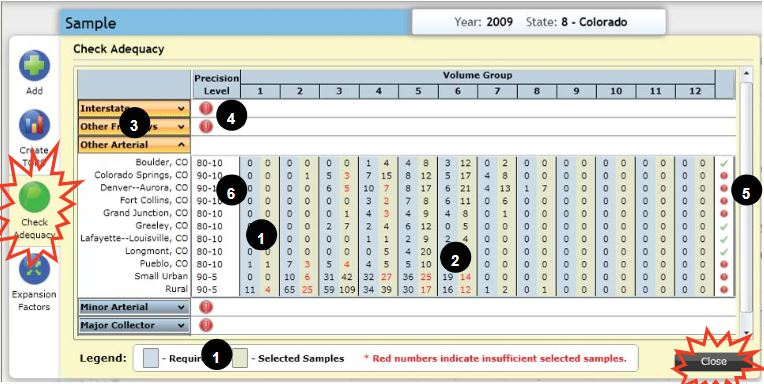

First, we will need to determine all the combinations of functional system, urban code, and volume group that exist in the TOPS:

In [208]:
# Retrieve the TOPS as a pandas dataframe
tops_sdf = pd.DataFrame.spatial.from_featureclass(tops_shp)
tops_sdf.head()

,FID,Route_ID,Begin_Poin,End_Point,aadt,f_system,facility_t,through_la,urban_code,LOC_ERROR,Shape_Leng,SHAPE
0,0,10015701,8.88,12.03,2798,3,2,2,99999,PARTIAL MATCH FOR THE TO-MEASURE,0.051173,"{'hasM': True, 'paths': [[[-74.59341805771555,..."
1,1,10015602,6.96,8.99,6287,4,2,2,99999,PARTIAL MATCH FOR THE FROM-MEASURE,0.031464,"{'hasM': True, 'paths': [[[-74.13269500000365,..."
2,2,10015601,0.28,0.44,16310,4,2,4,71803,PARTIAL MATCH FOR THE TO-MEASURE,0.002546,"{'hasM': True, 'paths': [[[-74.18884892975615,..."
3,3,10015601,0.87,3.81,15299,4,2,2,71803,PARTIAL MATCH FOR THE TO-MEASURE,0.047034,"{'hasM': True, 'paths': [[[-74.19017584008566,..."
4,4,10015601,16.81,19.45,10271,4,2,2,71803,PARTIAL MATCH FOR THE FROM-MEASURE AND TO-MEASURE,0.040243,"{'hasM': True, 'paths': [[[-74.2008559627161, ..."


In [209]:
# Set schema for HPMS / TOPS table
functional_system_field_name = "f_system"
facility_type_field_name = "facility_t"
urban_code_field_name = "urban_code"
aadt_field_name = "aadt"
through_lanes_field_name = "through_la"

route_id_field_name = "Route_ID"

In [210]:
# Get list of unique functional system values
func_sys_vals = tops_sdf[functional_system_field_name].unique().tolist()
func_sys_vals

[3, 4, 0, 5, 2, 1, 6, 7]

In [211]:
# Get list of unique functional system values
urban_code_vals = tops_sdf[urban_code_field_name].unique().tolist()
urban_code_vals

[99999, 71803, 0, 99998, 75664, 63217, 7732, 970, 11350, 45262, 33598, 92674, 86302, 89785, 27118, 41914, 79633]

For the list of volume groups, we'll reference the HPMS Field Guide to establish the AADT thresholds for each group:

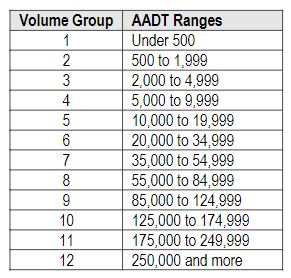

In [212]:
# Set volume groups based on aadt directions from HPMS Field Guide
vol_groups = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
vol_groups_aadt_dict = {
    "1": (0, 499),
    "2": (500,1999),
    "3": (2000,4999),
    "4": (5000,9999),
    "5": (10000,19999),
    "6": (20000,34999),
    "7": (35000,54999),
    "8": (55000,84999),
    "9": (85000,124999),
    "10": (125000,174999),
    "11": (175000,249999),
    "12": (250000,999999999)
}

In [213]:
# using list comprehension  
# to compute all possible permutations 
stratum_permutations_dict = [{"name": f"{str(i)}_{str(j)}_{str(k)}", 
                              "func_sys": i, 
                              "urban_code": j, 
                              "volume_group": k} for i in func_sys_vals  
                                                 for j in urban_code_vals 
                                                 for k in vol_groups]
print(f"There are a total of {len(stratum_permutations_dict)} permutations in the provided TOPS dataset.")

There are a total of 1632 permutations in the provided TOPS dataset.


In [214]:
stratum_permutations_dict[0]

{'name': '3_99999_1', 'func_sys': 3, 'urban_code': 99999, 'volume_group': '1'}

In [215]:
stratum_permutations_dict[0]['volume_group']

'1'

In [216]:
# Convert stratum permutations into a dataframe where each record is a stratum, and each column is a stratum component
stratum_df = pd.DataFrame.from_dict(stratum_permutations_dict)
stratum_df.head()

,name,func_sys,urban_code,volume_group
0,3_99999_1,3,99999,1
1,3_99999_2,3,99999,2
2,3_99999_3,3,99999,3
3,3_99999_4,3,99999,4
4,3_99999_5,3,99999,5


In [217]:
# Convert volume group into an aadt range to assist with queries later on
stratum_df["aadt_range"] = stratum_df.apply(lambda x: vol_groups_aadt_dict[x['volume_group']], axis=1)
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range
0,3_99999_1,3,99999,1,"(0, 499)"
1,3_99999_2,3,99999,2,"(500, 1999)"
2,3_99999_3,3,99999,3,"(2000, 4999)"
3,3_99999_4,3,99999,4,"(5000, 9999)"
4,3_99999_5,3,99999,5,"(10000, 19999)"


## Stratum Estimation Calculation Component Details

Stratum Object Components: 
- Z: Value of the standard normal statistic for an alpha confidence level (two-sided)
- d: Desired precision rate
- TOPS SQL Query
- N: TOPS or population stratum size
- C: Coefficient of variation

### d: Desired precision rate

The desired precision rate for the strata can be derived from the following table in the HPMS Field Guide:

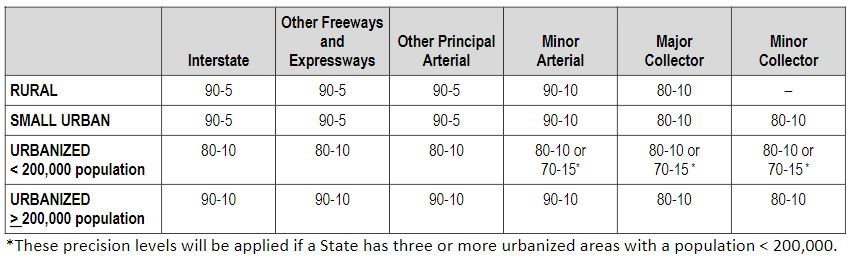

In [218]:
# For the New York state demonstration, we will hard-code the designations of 
# rural, small urban, medium urban, and large urban to each urban code
urban_code_designations_dict = {
        0: "rural", # Erroneous data
    99999: "rural",
    71803: "medium_urban", # Poughkeepsie--Newburgh
    99998: "small_urban", # Rural roads
    75664: "large_urban", # Rochester
    63217: "large_urban", # NYC
    7732: "small_urban", # Binghampton
    970: "large_urban", # Albany
    11350: "large_urban", # Buffalo
    45262: "medium_urban", # Kingston
    33598: "small_urban", # Glens Falls
    92674: "small_urban", # Watertown
    86302: "medium_urban", # Syracuse
    89785: "small_urban", # Utica
    27118: "small_urban", # Elmira
    41914: "small_urban", # Ithaca
    79633: "small_urban" # Saratoga Springs
}

# Now we can create a new column for each stratum and designate its urban type
stratum_df['urban_designation'] = stratum_df['urban_code'].astype(object)
stratum_df = stratum_df.replace({"urban_designation": urban_code_designations_dict})
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation
0,3_99999_1,3,99999,1,"(0, 499)",rural
1,3_99999_2,3,99999,2,"(500, 1999)",rural
2,3_99999_3,3,99999,3,"(2000, 4999)",rural
3,3_99999_4,3,99999,4,"(5000, 9999)",rural
4,3_99999_5,3,99999,5,"(10000, 19999)",rural


Furthermore, we will need a crosswalk between functional system values and their corresponding text designation:

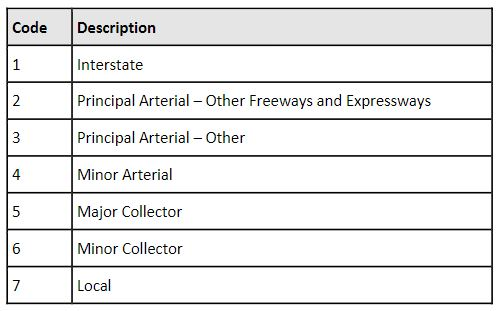

We will store these values in a python dictionary for further reference. 

In [219]:
d_vals_dict = {
    "rural":        {"1":(90,5), "2": (90, 5), "3": (90, 5), "4": (90, 10), "5": (80, 10), "6": (None, None), "7": (None, None), "0": (None, None)},
    "small_urban":  {"1":(90,5), "2": (90, 5), "3": (90, 5), "4": (90, 10), "5": (80, 10), "6": (80, 10), "7": (None, None), "0": (None, None)},
    "medium_urban": {"1":(80,10), "2": (80, 10), "3": (80, 10), "4": (80, 10), "5": (80, 10), "6": (80, 10), "7": (None, None), "0": (None, None)},
    "large_urban":  {"1":(90,10), "2": (90, 10), "3": (90, 10), "4": (90, 10), "5": (80, 10), "6": (80, 10), "7": (None, None), "0": (None, None)},
}

Now, we can calculate the needed precision rates to each stratum

In [220]:
stratum_df['d'] = stratum_df.apply(lambda x: d_vals_dict[x['urban_designation']][str(x['func_sys'])], axis=1)
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)"
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)"
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)"
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)"
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)"


### Z: Value of Standard normal statistic

The value of the standard normal statistic can be derived from the below table and expressed as a python dictionary, where the desired confidence level is the key and the resulting Z value is the dictionary value. 

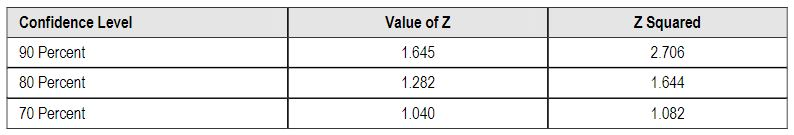

In [221]:
z_vals_dict = {
    "90": 1.645,
    "80": 1.282,
    "70": 1.040,
    "None": None
}

In [222]:
# Calculate Z values for each stratum
stratum_df['Z'] = stratum_df.apply(lambda x: z_vals_dict[str(x['d'][0])], axis=1)
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645


### N: TOPS SQL Query and Population Size Calculation

This section outlines the SQL queries needed for each stratum object, retrieves the data for each stratum, and assigns this value as N for each stratum. 

In [223]:
test_df = tops_sdf.query('{0} == {1} and {2} == {3} and {4} >= {5} and {6} <= {7}'.format(functional_system_field_name, 
                                                                                          stratum_df.iloc[0]["func_sys"],
                                                                                          urban_code_field_name,
                                                                                          stratum_df.iloc[0]["urban_code"],
                                                                                          aadt_field_name,
                                                                                          stratum_df.iloc[0]["aadt_range"][0],
                                                                                          aadt_field_name,
                                                                                          stratum_df.iloc[0]["aadt_range"][1],
                                                                                          ))
test_df.shape

(121, 12)

In [224]:
stratum_df['tops_query'] = stratum_df.apply(lambda x: '{0} == {1} and {2} == {3} and {4} >= {5} and {6} <= {7}'.format(functional_system_field_name, 
                                                                                                                       x["func_sys"],
                                                                                                                       urban_code_field_name,
                                                                                                                       x["urban_code"],
                                                                                                                       aadt_field_name,
                                                                                                                       x["aadt_range"][0],
                                                                                                                       aadt_field_name,
                                                                                                                       x["aadt_range"][1],
                                                                                                                       ), axis=1)

stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z,tops_query
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...


In [225]:
stratum_df['N'] = stratum_df.apply(lambda x: tops_sdf.query(x['tops_query']).shape[0], axis=1)
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z,tops_query,N
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,121
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,131
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,382
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,311
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,126


### C: Coefficient of Variance Calculation

This section uses a calculation for variance in the available AADT data for each stratum.

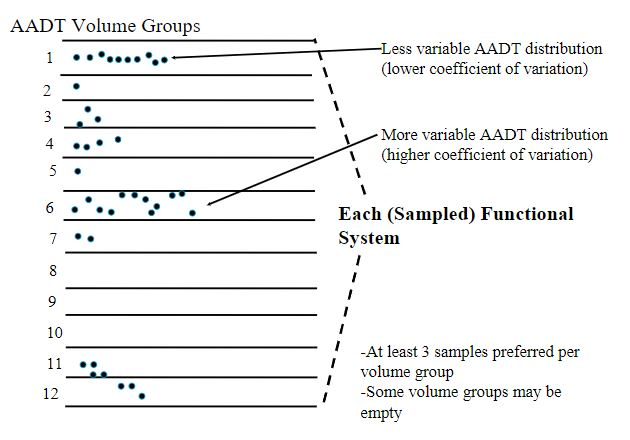

The HPMS Field Guide did not provide detail for this calculation, so a placeholder is used. 

In [226]:
stratum_df['C'] = 0.4
stratum_df.head()

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z,tops_query,N,C
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,121,0.4
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,131,0.4
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,382,0.4
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,311,0.4
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,126,0.4


## Sample Size Estimation for Stratum

Next, the sample size estimation formula is applied to determine the amount of samples needed per stratum

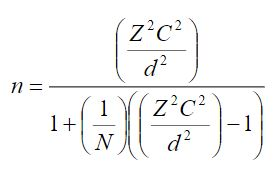

In [268]:
def return_sample_size(Z, C, d, N):
    if N == 0:
        return(0)
    elif not d:
        return(0)
    else:
        numerator = ((Z**2) * (C**2)) / ((d*0.01)**2)
        denominator = 1 + (1/N) * ((numerator)-1)
    return(int(numerator / denominator))

In [269]:
stratum_df

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z,tops_query,N,C,n
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,121,0.4,71.0
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,131,0.4,75.0
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,382,0.4,119.0
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,311,0.4,111.0
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,126,0.4,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,7_79633_8,7,79633,8,"(55000, 84999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0.0
1628,7_79633_9,7,79633,9,"(85000, 124999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0.0
1629,7_79633_10,7,79633,10,"(125000, 174999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0.0
1630,7_79633_11,7,79633,11,"(175000, 249999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0.0


In [270]:
stratum_df['n'] = stratum_df.apply(lambda x: return_sample_size(x['Z'], x['C'], x['d'][1], x['N']), axis=1)
stratum_df

,name,func_sys,urban_code,volume_group,aadt_range,urban_designation,d,Z,tops_query,N,C,n
0,3_99999_1,3,99999,1,"(0, 499)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,121,0.4,71
1,3_99999_2,3,99999,2,"(500, 1999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,131,0.4,74
2,3_99999_3,3,99999,3,"(2000, 4999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,382,0.4,119
3,3_99999_4,3,99999,4,"(5000, 9999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,311,0.4,111
4,3_99999_5,3,99999,5,"(10000, 19999)",rural,"(90, 5)",1.645,f_system == 3 and urban_code == 99999 and aadt...,126,0.4,73
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,7_79633_8,7,79633,8,"(55000, 84999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0
1628,7_79633_9,7,79633,9,"(85000, 124999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0
1629,7_79633_10,7,79633,10,"(125000, 174999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0
1630,7_79633_11,7,79633,11,"(175000, 249999)",small_urban,"(None, None)",NaN,f_system == 7 and urban_code == 79633 and aadt...,0,0.4,0


In [279]:
stratum_df['n'].describe()

count    1632.000000
mean        4.651348
std        11.043824
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max       119.000000
Name: n, dtype: float64